In [10]:
import os
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Helper function
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()

In [12]:
def relu(x):
    return np.maximum(0,x)  

def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Load numpy array

In [13]:
# ft_ls = os.listdir('./npy/mask1ft/')
ft_ls = ['mask_image.npy']

In [14]:
def loadFt(PATH):
    return np.load(PATH)

# Normalize usr_genre
def ugNorm(usr_genre):
    usr_genre_norm = np.zeros(usr_genre.shape)
    for i in range(len(usr_genre)):
        usr_genre_norm[i] = usr_genre[i]/np.max(usr_genre[i])
    print(usr_genre_norm.shape)
    return usr_genre_norm

In [15]:
def train_test_split(usr_following):
    #The number of following movie for each user
    each_user = np.sum(usr_following, axis=1)
    # print(each_user)

    print('Min number of followings:', np.min(each_user))
    print('Max number of followings:', np.max(each_user))
    print('Avg of followers:', np.mean(each_user))

    asc = np.sort(each_user)
    # print(each_user)
    # print(asc)
    desc = np.flip(asc)
    # print(desc)
    
    print('Over 10:', np.sum(each_user >= 10))
    print('Over 12:', np.sum(each_user >= 12))
    print('Over 14:', np.sum(each_user >= 14))
    print('Over 16:', np.sum(each_user >= 16))
    print('Over 18:', np.sum(each_user >= 18))
    print('Over 20:', np.sum(each_user >= 20))
    
    usr_idx = [i for i in range(len(usr_following))]
    print(len(usr_idx))

    random.seed(42)
    test_idx = sorted(random.sample(usr_idx, usr_test_amount))
    print(len(test_idx), test_idx[:10]) # 150 [13, 51, 54, 61, 65, 88, 93, 96, 114, 130]

    # init
    train_t = []
    train_f = []
    test_t = []
    test_f = []

    for i in range(usr_nb):
        # init
        t_for_train = []
        f_for_train = []
        t_for_test = []
        f_for_test = []

        if i not in test_idx: #if not in test id, just append it to true or false list
            for j in range(movie_nb):
                if usr_following[i][j] == 1:
                    t_for_train.append(j)
                else:
                    f_for_train.append(j)

            train_t.append(t_for_train)
            train_f.append(f_for_train)
    #         print(len(t_for_train) + len(f_for_train))

        else: #if in test id, choose half of true and other 
            temp_t = []
            temp_f = []

            for j in range(movie_nb):
                if usr_following[i][j] == 1:
                    temp_t.append(j)
                else:
                    temp_f.append(j)

            # random choose half true and half false for test 
            t_for_test = random.sample(temp_t, math.ceil(0.5*len(temp_t)))
            f_for_test  = random.sample(temp_f, movie_test_amount-len(t_for_test))

            test_t.append(t_for_test)
            test_f.append(f_for_test)

            #the others for training
            t_for_train = [item for item in temp_t if not item in t_for_test]
            f_for_train = [item for item in temp_f if not item in f_for_test]
            train_t.append(t_for_train)
            train_f.append(f_for_train)

        if not (len(t_for_train) + len(f_for_train) + len(t_for_test) + len(f_for_test)) == movie_nb:
            print('Error!!!')
            break
    
    return train_t, train_f, test_t, test_f

In [16]:
# Basic setup
usr_following = np.load('./npy/user_followings.npy')
usr_genre = np.load('./npy/user_genre.npy')
movie_genre = np.load('./npy/movie_genre.npy')

print('Movie genre:', movie_genre.shape)
print('User following:', usr_following.shape)
print('User genre:', usr_genre.shape)

usr_nb = len(usr_following) # the number of users
movie_nb = len(movie_genre)  # the number of movies
print(usr_nb, movie_nb)

usr_test_amount = 150
movie_test_amount = 32
print(usr_test_amount, movie_test_amount)

usr_genre_norm = ugNorm(usr_genre)
train_t, train_f, test_t, test_f = train_test_split(usr_following)

# Stat
#average num of following for training user
total_train = 0
for t in train_t:
    total_train += len(t)
avg = total_train / usr_nb
print('Training:', avg)

#average num of following for testing user
total_test = 0
for t in test_t:
    total_test += len(t)
avg = total_test / usr_test_amount
print('Testing:', avg)

all_auxilary = [i for i in range(movie_nb)]

Movie genre: (165, 20)
User following: (1582, 165)
User genre: (1582, 20)
1582 165
150 32
(1582, 20)
Min number of followings: 10
Max number of followings: 133
Avg of followers: 14.820480404551201
Over 10: 1582
Over 12: 937
Over 14: 613
Over 16: 440
Over 18: 315
Over 20: 229
1582
150 [13, 51, 54, 61, 65, 88, 93, 96, 114, 130]
Training: 14.139064475347661
Testing: 7.1866666666666665


In [17]:
def training(SAVE_NAME):
    print('==================================================')
    print(SAVE_NAME)
    print('Start time:', time.ctime())

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    loss_acc_list = []
    t0 = time.time()

    train_yes_id=[]

    for q in range(6):
        print('Epoch:',q)
        train_auc = 0
        total_loss = 0
        xuij_auc = 0
        length = 0

        for z in range(usr_nb):
            writeProgress('Progress:', z, usr_nb)
            """
            yes 用來存放選擇到的YouTuber feature (for auxilary)
            yesr 用來存放user對該YouTuber的喜好程度(user_category 跟 YouTuber_category的相似性)
            r_3 用來存放user 對該YouTuber種類的偏好(取max)
            """
            yes = []
            yesr = []

    #         #選全部的Positive
    #         sample = random.sample(train_t[z],len(train_t[z]))
            #選全部的電影
            sample = all_auxilary

            #change
            r_3 = np.zeros(len(sample))

            for b in range(len(sample)):
                yes.append(all_npy[sample[b]])
                yesr.append(movie_genre[sample[b]] * usr_genre_norm[z])

            for b in range(len(yesr)):
                r_3[b]=max(yesr[b])
            #print('r_3:',r_3)

            yes = np.array(yes)

            # positive sample
            train_t_sample = train_t[z]
            for ta in train_t_sample:
                #print(ta,'--> positive feedback')

                pos = sample.index(ta)

                image_1=np.expand_dims(all_npy[ta],0)
                train_f_sample = random.sample(train_f[z],10)

                for b in train_f_sample:
                    image_2 = np.expand_dims(all_npy[b],0)

                    _last_be_relu, _norm_par, _a_list, r3, _auc, _loss, _ = sess.run(
                        [last_be_relu, norm_par, a_list_smooth, a_list_soft, auc, loss, train_op], 
                        feed_dict={user: [z], i: [ta], j: [b], xf: yes, 
                                   l_id:sample, l_id_len:[len(sample)],
                                   positive_id: train_t[z], positive_len:[len(train_t[z])],
                                   r: r_3, image_i: image_1, image_j: image_2})

                    '''Observe all params
                    print('u,vi,vj',_norm_par[:3])
                    print('w1,wu,wy,wa,wv',_norm_par[3:7])
                    print('beta',_norm_par[7])
                    print('Embedding',_norm_par[8])
                    print('after softmax:', r3)
                    print('before softmax:', _a_list)
                    print('---------------------------------------------------')
                    '''
                    train_auc += _auc
                    total_loss += _loss
                    length += 1

        print("{:<20}{}".format('total_loss', total_loss/length))
        print("{:<20}{}".format('train_auc:', train_auc/length))

        loss_acc_list.append([total_loss/length, train_auc/length])

        print('\tCurrent time:', time.ctime(), ' sec')
        print('==================================================')

    print('Total cost time:',time.time()-t0, ' sec')

    print('End time:', time.ctime())
    
    U, Y, A, E, Au, Ay, Aa, Av, B = sess.run([user_latent, item_latent, aux_item, embedding, Wu, Wy, Wa, Wv, Beta])
    np.savez('./weight/mask1ft/' + SAVE_NAME + '.npz',
             U=U, Y=Y, A=A, E=E, Wu=Au, Wy=Ay, Wa=Aa, Wv=Av, B=B)
    
    return loss_acc_list

mask_image.npy
All features: (165, 324)
64 324 240
SAVE_NAME: mask_image
mask_image
Start time: Mon Apr 13 17:32:35 2020
Epoch: 0
total_loss          [[0.64970473]]
train_auc:          0.6708065092989985
	Current time: Mon Apr 13 20:55:41 2020  sec
Epoch: 1
total_loss          [[0.58341286]]
train_auc:          0.7171897353361946
	Current time: Tue Apr 14 00:18:48 2020  sec
Epoch: 2
total_loss          [[0.55388425]]
train_auc:          0.7453192060085837
	Current time: Tue Apr 14 03:41:45 2020  sec
Epoch: 3
total_loss          [[0.53314483]]
train_auc:          0.7619858726752503
	Current time: Tue Apr 14 07:04:53 2020  sec
Epoch: 4
total_loss          [[0.51648581]]
train_auc:          0.7732162017167382
	Current time: Tue Apr 14 10:28:09 2020  sec
Epoch: 5
total_loss          [[0.5071368]]
train_auc:          0.7824123748211731
	Current time: Tue Apr 14 13:51:50 2020  sec
Total cost time: 73153.24512696266  sec
End time: Tue Apr 14 13:51:50 2020
Epoch: range(1, 7)
Loss: [0.649704726

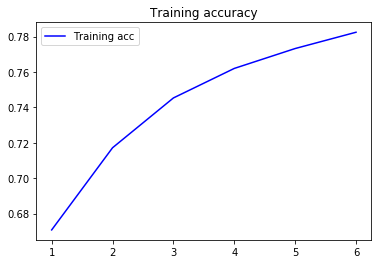

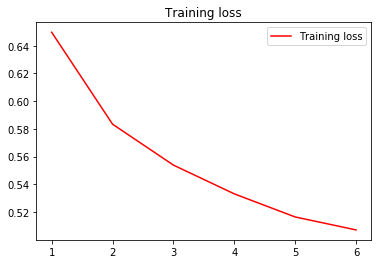

In [18]:
for ft in ft_ls:
    print(ft)
    PATH = './npy/mask1ft/' + ft
    all_npy = loadFt(PATH)
    print('All features:', all_npy.shape)
    
    latent_dim = 64 # latent dims
    ft_dim = all_npy.shape[1] # feature dims
    embedding_dims = 240
    print(latent_dim, ft_dim, embedding_dims)
    
    SAVE_NAME = ft.split('.')[0]
    print('SAVE_NAME:', SAVE_NAME)
    
    tf.reset_default_graph()

    user = tf.placeholder(tf.int32,shape=(1,))
    i = tf.placeholder(tf.int32, shape=(1,))
    j = tf.placeholder(tf.int32, shape=(1,))

    #多少個auxliary 
    xf = tf.placeholder(tf.float32, shape=(None, ft_dim))
    l_id = tf.placeholder(tf.int32, shape=(None,))
    l_id_len = tf.placeholder(tf.int32,shape=(1,))
    r = tf.placeholder(tf.float32,shape=(None,))
    positive_id = tf.placeholder(tf.int32, shape=(None,))
    positive_len = tf.placeholder(tf.int32,shape=(1,))

    image_i = tf.placeholder(tf.float32, [1, ft_dim])
    image_j = tf.placeholder(tf.float32, [1, ft_dim])

    with tf.variable_scope("item_level"):
        user_latent = tf.get_variable("user_latent", [usr_nb, latent_dim],
                                      initializer=tf.random_normal_initializer(0,0.1,seed=3))
        item_latent = tf.get_variable("item_latent", [movie_nb, latent_dim],
                                      initializer=tf.random_normal_initializer(0,0.1,seed=3)) 
        aux_item = tf.get_variable("aux_item", [movie_nb, latent_dim],
                                   initializer=tf.random_normal_initializer(0,0.1,seed=3))

    #     W1 = tf.get_variable("W1", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
        Wu = tf.get_variable("Wu", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
        Wy = tf.get_variable("Wy", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
        Wa = tf.get_variable("Wa", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
        Wv = tf.get_variable("Wv", [usr_nb, movie_nb, embedding_dims], initializer=tf.contrib.layers.xavier_initializer())
    #     Wve = tf.get_variable("Wve", [embedding_dims, ft_dim], initializer=tf.contrib.layers.xavier_initializer())

        aux_new = tf.get_variable("aux_new", [1, latent_dim], initializer=tf.constant_initializer(0.0))

    with tf.variable_scope('feature_level'):
        embedding = tf.get_variable("embedding", [embedding_dims,ft_dim],
                                    initializer=tf.contrib.layers.xavier_initializer())
        Beta = tf.get_variable("beta", [usr_nb, embedding_dims],
                               initializer=tf.random_normal_initializer(0.01, 0.001, seed=10))

    #lookup the latent factors by user and id
    u = tf.nn.embedding_lookup(user_latent, user)
    vi = tf.nn.embedding_lookup(item_latent, i)
    vj = tf.nn.embedding_lookup(item_latent, j)

    # w1 = tf.nn.embedding_lookup(W1, user)
    wu = tf.squeeze(tf.nn.embedding_lookup(Wu, user))
    wy = tf.squeeze(tf.nn.embedding_lookup(Wy, user))
    wa = tf.squeeze(tf.nn.embedding_lookup(Wa, user))
    wv = tf.squeeze(tf.nn.embedding_lookup(Wv, user))

    beta = tf.nn.embedding_lookup(Beta, user) #user feature latent factor
    
    a_list = tf.Variable([])
    q = tf.constant(0)

    def att_cond(q,a_list):
        return tf.less(q,l_id_len[0])

    def att_body(q,a_list):
        xfi = tf.expand_dims(xf[q],0) #(1,l)
        wuui = tf.expand_dims(tf.nn.embedding_lookup(wu,l_id[q]),0) #取該YOUTUBER那欄(1,K)
        wyui = tf.expand_dims(tf.nn.embedding_lookup(wy,l_id[q]),0) #取該YOUTUBER那欄(1,K)
        waui = tf.expand_dims(tf.nn.embedding_lookup(wa,l_id[q]),0) #取該YOUTUBER那欄(1,K)
        wvui = tf.expand_dims(tf.nn.embedding_lookup(wv,l_id[q]),0) #取該YOUTUBER那欄(1,K)

        a_list = tf.concat([a_list,[(tf.nn.relu(tf.matmul(wuui, u, transpose_b=True) +
                                                tf.matmul(wyui, tf.expand_dims(tf.nn.embedding_lookup(item_latent,l_id[q]),0), transpose_b=True) +
                                                tf.matmul(waui, tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[q]),0), transpose_b=True) +
                                                tf.matmul(wvui, tf.matmul(embedding,xfi, transpose_b=True)))[0][0])*r[q]]],0)
        q += 1
        return q, a_list

    _, a_list = tf.while_loop(att_cond,att_body,[q,a_list],shape_invariants=[q.get_shape(),tf.TensorShape([None])])

    a_list_smooth = tf.add(a_list,0.0000000001)
    a_list_soft = tf.divide(a_list_smooth,tf.reduce_sum(a_list_smooth, 0)) #without softmax

    norm_par = [wu,wy,wa,wv]

    wuui = tf.expand_dims(tf.nn.embedding_lookup(wu,l_id[-1]),0)
    wyui = tf.expand_dims(tf.nn.embedding_lookup(wy,l_id[-1]),0)
    waui = tf.expand_dims(tf.nn.embedding_lookup(wa,l_id[-1]),0)
    wvui = tf.expand_dims(tf.nn.embedding_lookup(wv,l_id[-1]),0)
    wu_be_relu = tf.matmul(wuui, u, transpose_b=True)
    wy_be_relu = tf.matmul(wyui, tf.expand_dims(tf.nn.embedding_lookup(item_latent,l_id[-1]),0), transpose_b=True)
    wa_be_relu = tf.matmul(waui, tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[-1]),0), transpose_b=True)
    wv_be_relu = tf.matmul(wvui, tf.matmul(embedding,tf.expand_dims(xf[-1],0), transpose_b=True))

    last_be_relu = [wu_be_relu,wy_be_relu,wa_be_relu,wv_be_relu]

    aux_np = tf.expand_dims(tf.zeros(latent_dim),0)
    q = tf.constant(0)

    def sum_att_cond(q,aux_np):
        return tf.less(q,l_id_len[0])

    def sum_att_body(q,aux_np):
        aux_np = tf.math.add_n([aux_np,a_list_soft[q]*tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[q]),0)]) 
        q += 1
        return q, aux_np

    _, aux_np = tf.while_loop(sum_att_cond, sum_att_body, [q,aux_np])

    aux_part = tf.matmul(aux_np, vi, transpose_b=True)
    aux_np += u #user_latent factor + sum (alpha*auxilary)
    aux_new = tf.assign(aux_new,aux_np) #把aux_new 的 值變成aux_np

    latent_i_part = tf.matmul(aux_new, vi, transpose_b=True)
    feature_i_part = tf.matmul(beta,(tf.matmul(embedding,image_i, transpose_b=True)))
    latent_j_part = tf.matmul(aux_new, vj, transpose_b=True)
    feature_j_part = tf.matmul(beta,(tf.matmul(embedding,image_j, transpose_b=True)))
    only_aux_i_part = tf.matmul(aux_np, vi, transpose_b=True)
    only_aux_j_part = tf.matmul(aux_np, vj, transpose_b=True)

    #矩陣中對應函數各自相乘
    # ex: tf.matmul(thetav,(tf.matmul(embedding, image_i, transpose_b=True)))
    xui = tf.matmul(aux_new, vi, transpose_b=True)+ tf.matmul(beta,(tf.matmul(embedding,image_i, transpose_b=True)))
    xuj = tf.matmul(aux_new, vj, transpose_b=True)+ tf.matmul(beta,(tf.matmul(embedding,image_j, transpose_b=True)))

    xuij = tf.subtract(xui,xuj)

    l2_norm = tf.add_n([
                0.0001 * tf.reduce_sum(tf.multiply(u, u)),
                0.0001 * tf.reduce_sum(tf.multiply(vi, vi)),
                0.0001 * tf.reduce_sum(tf.multiply(vj, vj)),

                0.01 * tf.reduce_sum(tf.multiply(wu, wu)),
                0.01 * tf.reduce_sum(tf.multiply(wy, wy)),
                0.01 * tf.reduce_sum(tf.multiply(wa, wa)),
                0.01 * tf.reduce_sum(tf.multiply(wv,wv)),

                0.001 * tf.reduce_sum(tf.multiply(beta,beta)),
                0.01 * tf.reduce_sum(tf.multiply(embedding,embedding))
              ])

    loss = l2_norm - tf.log(tf.sigmoid(xuij)) # objective funtion
    train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss) #parameter optimize 
    auc = tf.reduce_mean(tf.to_float(xuij > 0))
    
    loss_acc_list = training(SAVE_NAME)
    
    # training history
    epochs = range(1, len(loss_acc_list) + 1)
    print('Epoch:', epochs)
    loss = [ls[0].tolist()[0][0] for ls in loss_acc_list]
    print('Loss:', loss)
    acc = [ls[1] for ls in loss_acc_list]
    print('Acc:', acc)
    print('==================================================')
    
    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()
#     print('==================================================')